# `pairwise_winner_odds_baseline.ipynb`

### Author: Anthony Hein

#### Last updated: 11/14/2021

# Overview:

Computes the performance of a baseline for selecting a pairwise winner which selects the one with the better odds. When the odds are equal, the baseline selects either horse with equal probability.

---

## Setup

In [4]:
from datetime import datetime
import git
import os
import re
from typing import List
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `X_train_everything.csv`

In [6]:
X_train_everything = pd.read_csv(f"{BASE_DIR}/data/analysis/X_train_everything.csv", low_memory=False)
X_train_everything.head()

,rid,horse1_horseName,horse1_age,horse1_saddle,horse1_decimalPrice,horse1_isFav,horse1_trainerName,horse1_jockeyName,horse1_position,horse1_positionL,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
0,341451,Dance Design,3.0,6.0,0.181818,0,D K Weld,Mick Kinane,2,1.5,...,0,1,0,0,0,0,1,0,0,1.601872
1,341451,Idris,6.0,1.0,0.066667,0,J S Bolger,Kevin Manning,5,nk,...,0,1,0,0,0,0,1,0,0,1.601872
2,50025,Azra,2.0,11.0,0.090909,0,J S Bolger,Kevin Manning,3,1,...,0,1,0,0,0,0,1,0,0,2.103465
3,50025,Azra,2.0,11.0,0.090909,0,J S Bolger,Kevin Manning,3,1,...,0,1,0,0,0,0,1,0,0,2.103465
4,50025,Johan Cruyff,2.0,5.0,0.083333,0,A P O'Brien,Johnny Murtagh,5,nk,...,0,1,0,0,0,0,1,0,0,2.103465


In [7]:
X_train_everything.shape

(800666, 295)

---

## Load `X_dev_everything.csv`

In [8]:
X_dev_everything = pd.read_csv(f"{BASE_DIR}/data/analysis/X_dev_everything.csv", low_memory=False)
X_dev_everything.head()

,rid,horse1_horseName,horse1_age,horse1_saddle,horse1_decimalPrice,horse1_isFav,horse1_trainerName,horse1_jockeyName,horse1_position,horse1_positionL,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
0,159686,Gussy Goose,4.0,2.0,0.181818,0,David Wachman,Wayne Lordan,5,1.75,...,1,0,0,1,0,0,0,0,1,1.852846
1,159686,Mothers Finest,4.0,4.0,0.142857,0,Adrian Paul Keatley,Gary Carroll,7,2.5,...,1,0,0,1,0,0,0,0,1,1.852846
2,159686,Mothers Finest,4.0,4.0,0.142857,0,Adrian Paul Keatley,Gary Carroll,7,2.5,...,1,0,0,1,0,0,0,0,1,1.852846
3,159686,Mothers Finest,4.0,4.0,0.142857,0,Adrian Paul Keatley,Gary Carroll,7,2.5,...,1,0,0,1,0,0,0,0,1,1.852846
4,159686,Mothers Finest,4.0,4.0,0.142857,0,Adrian Paul Keatley,Gary Carroll,7,2.5,...,1,0,0,1,0,0,0,0,1,1.852846


In [9]:
X_dev_everything.shape

(228766, 295)

---

## Load `X_test_everything.csv`

In [10]:
X_test_everything = pd.read_csv(f"{BASE_DIR}/data/analysis/X_test_everything.csv", low_memory=False)
X_test_everything.head()

,rid,horse1_horseName,horse1_age,horse1_saddle,horse1_decimalPrice,horse1_isFav,horse1_trainerName,horse1_jockeyName,horse1_position,horse1_positionL,...,pressure_level_2,pressure_level_3,pressure_level_4,is_raining,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4,entropy of odds
0,136782,Sestriere,3.0,7.0,0.029412,0,Kevin Prendergast,Chris Hayes,7,.75,...,1,0,0,0,0,0,1,0,0,2.306015
1,136782,Sestriere,3.0,7.0,0.029412,0,Kevin Prendergast,Chris Hayes,7,.75,...,1,0,0,0,0,0,1,0,0,2.306015
2,136782,Sestriere,3.0,7.0,0.029412,0,Kevin Prendergast,Chris Hayes,7,.75,...,1,0,0,0,0,0,1,0,0,2.306015
3,136782,Sestriere,3.0,7.0,0.029412,0,Kevin Prendergast,Chris Hayes,7,.75,...,1,0,0,0,0,0,1,0,0,2.306015
4,136782,Sestriere,3.0,7.0,0.029412,0,Kevin Prendergast,Chris Hayes,7,.75,...,1,0,0,0,0,0,1,0,0,2.306015


In [11]:
X_test_everything.shape

(114392, 295)

---

## Load Pairwise Winner Labels

In [34]:
X_train_pairwise_winner_labels = np.loadtxt(f"{BASE_DIR}/data/analysis/x_train_pairwise_winner_labels.csv",
                                            dtype=int,
                                            delimiter=',')

In [35]:
X_dev_pairwise_winner_labels = np.loadtxt(f"{BASE_DIR}/data/analysis/X_dev_pairwise_winner_labels.csv",
                                          dtype=int,
                                          delimiter=',')

In [36]:
X_test_pairwise_winner_labels = np.loadtxt(f"{BASE_DIR}/data/analysis/X_test_pairwise_winner_labels.csv",
                                           dtype=int,
                                           delimiter=',')

In [37]:
X_train_pairwise_winner_labels[:10]

array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])

---

## Compute Baseline Predictions

Recall, a horse with a higher `decimalPrice` is projected to do better.

In [38]:
def get_predicted_pairwise_winner(row: pd.core.frame.DataFrame) -> int:
    """
    Implements the labeling scheme described above.
    """
    if row['horse1_decimalPrice'] > row['horse2_decimalPrice']:
        return 1
    elif row['horse1_decimalPrice'] < row['horse2_decimalPrice']:
        return 0
    else:
        return 0

In [39]:
X_train_everything[['horse1_horseName', 'horse1_decimalPrice', 'horse2_horseName', 'horse2_decimalPrice']].head()

,horse1_horseName,horse1_decimalPrice,horse2_horseName,horse2_decimalPrice
0,Dance Design,0.181818,Idris,0.066667
1,Idris,0.066667,Dance Design,0.181818
2,Azra,0.090909,Johan Cruyff,0.083333
3,Azra,0.090909,Beautiful Fire,0.153846
4,Johan Cruyff,0.083333,Azra,0.090909


In [40]:
X_train_everything[
 X_train_everything['horse1_decimalPrice'] == X_train_everything['horse2_decimalPrice']   
][['horse1_horseName', 'horse1_decimalPrice', 'horse2_horseName', 'horse2_decimalPrice']].head()

,horse1_horseName,horse1_decimalPrice,horse2_horseName,horse2_decimalPrice
15,Prairie Flame,0.090909,Magical Cliche,0.090909
17,Magical Cliche,0.090909,Prairie Flame,0.090909
35,Elida,0.266667,Red Castle I,0.266667
45,Red Castle I,0.266667,Elida,0.266667
68,Caiseal Ros,0.111111,Keyboogie,0.111111


In [41]:
assert get_predicted_pairwise_winner(X_train_everything.iloc[0]) == 1
assert get_predicted_pairwise_winner(X_train_everything.iloc[1]) == 0
assert get_predicted_pairwise_winner(X_train_everything.iloc[15]) == 0
assert get_predicted_pairwise_winner(X_train_everything.iloc[17]) == 0

In [42]:
X_train_predictions = np.array(X_train_everything.apply(get_predicted_pairwise_winner, axis=1), dtype=int)

In [43]:
X_dev_predictions = np.array(X_dev_everything.apply(get_predicted_pairwise_winner, axis=1), dtype=int)

In [44]:
X_test_predictions = np.array(X_test_everything.apply(get_predicted_pairwise_winner, axis=1), dtype=int)

---

## Evaluate Performance

There are 4 possibilities:
1. The odds are not equal and the horses do not tie: the baseline is either right twice or wrong twice.
2. The odds are equal and the horses do not tie: the baseline is right once and wrong once.
3. The odds are not equal and the horses tie: the baseline is right once and wrong once.
4. The odds are equal and the horses tie: the baseline is right twice.

Does possibility 4 even occur?

In [48]:
len(X_train_everything[
    (X_train_everything['horse1_position'] == X_train_everything['horse2_position']) & 
    (X_train_everything['horse1_decimalPrice'] == X_train_everything['horse2_decimalPrice'])
])

26

In [52]:
len(X_dev_everything[
    (X_dev_everything['horse1_position'] == X_dev_everything['horse2_position']) & 
    (X_dev_everything['horse1_decimalPrice'] == X_dev_everything['horse2_decimalPrice'])
])

2

In [51]:
len(X_test_everything[
    (X_test_everything['horse1_position'] == X_test_everything['horse2_position']) & 
    (X_test_everything['horse1_decimalPrice'] == X_test_everything['horse2_decimalPrice'])
])

6

We only really care about accuracy since false negatives and positives don't have meaning in this context.

In [57]:
print(f"Accuracy train set: {np.mean(X_train_pairwise_winner_labels == X_train_predictions) * 100}")

Accuracy: 67.6695401078602


In [60]:
print(f"Accuracy dev set: {np.mean(X_dev_pairwise_winner_labels == X_dev_predictions) * 100}")

Accuracy dev set: 68.85332610615214


In [59]:
print(f"Accuracy test set: {np.mean(X_test_pairwise_winner_labels == X_test_predictions) * 100}")

Accuracy test set: 68.7032309951745


Is the baseline better when the odds are farther apart?

In [61]:
X_train_everything['prediction'] = 1 - abs(X_train_pairwise_winner_labels - X_train_predictions)
X_train_everything['prediction'].head()

0    1
1    1
2    1
3    0
4    1
Name: prediction, dtype: int64

In [65]:
assert sum(X_train_pairwise_winner_labels == X_train_predictions) == sum(X_train_everything['prediction'])

In [68]:
X_train_everything['price_diff'] = abs(X_train_everything['horse1_decimalPrice'] - \
                                       X_train_everything['horse2_decimalPrice'])
X_train_everything['price_diff'].head()

0    0.115152
1    0.115152
2    0.007576
3    0.062937
4    0.007576
Name: price_diff, dtype: float64

In [69]:
np.corrcoef(X_train_everything['prediction'], X_train_everything['price_diff'])

array([[1.        , 0.19708666],
       [0.19708666, 1.        ]])

The correlation is weak.

However, we can show some pretty apparent correlation here:

In [77]:
np.mean(X_train_everything[X_train_everything['price_diff'] < 0.025]['prediction'])

0.5485110275434495

In [74]:
np.mean(X_train_everything[X_train_everything['price_diff'] < 0.05]['prediction'])

0.5792889594000145

In [71]:
np.mean(X_train_everything[X_train_everything['price_diff'] < 0.1]['prediction'])

0.6151117554296907

In [72]:
np.mean(X_train_everything[X_train_everything['price_diff'] >= 0.1]['prediction'])

0.7899973044292483

In [73]:
np.mean(X_train_everything[X_train_everything['price_diff'] >= 0.2]['prediction'])

0.84709320880856

In [76]:
np.mean(X_train_everything[X_train_everything['price_diff'] >= 0.4]['prediction'])

0.9007190828302015

Let's make a curve of this:

In [107]:
def get_predicted_pairwise_winner_prob(row: pd.core.frame.DataFrame) -> int:
    """
    Implements the labeling scheme described above.
    """
    return 0.5 + row['horse1_decimalPrice'] - row['horse2_decimalPrice']

In [108]:
X_train_everything[['horse1_horseName', 'horse1_decimalPrice', 'horse2_horseName', 'horse2_decimalPrice']].head()

,horse1_horseName,horse1_decimalPrice,horse2_horseName,horse2_decimalPrice
0,Dance Design,0.181818,Idris,0.066667
1,Idris,0.066667,Dance Design,0.181818
2,Azra,0.090909,Johan Cruyff,0.083333
3,Azra,0.090909,Beautiful Fire,0.153846
4,Johan Cruyff,0.083333,Azra,0.090909


In [109]:
print(get_predicted_pairwise_winner_prob(X_train_everything.iloc[0]))
print(get_predicted_pairwise_winner_prob(X_train_everything.iloc[1]))
print(get_predicted_pairwise_winner_prob(X_train_everything.iloc[15]))
print(get_predicted_pairwise_winner_prob(X_train_everything.iloc[17]))

0.6151515151515152
0.3848484848484849
0.5
0.5


In [110]:
X_train_predictions_prob = np.array(X_train_everything.apply(get_predicted_pairwise_winner_prob, axis=1), dtype=int)

In [111]:
X_dev_predictions_prob = np.array(X_dev_everything.apply(get_predicted_pairwise_winner_prob, axis=1), dtype=int)

In [112]:
X_test_predictions_prob = np.array(X_test_everything.apply(get_predicted_pairwise_winner_prob, axis=1), dtype=int)

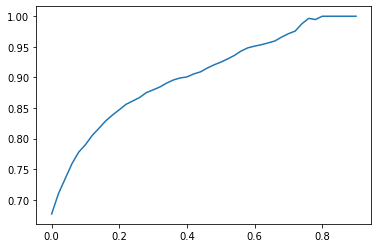

In [113]:
xs = np.arange(0, max(X_train_everything['price_diff']), 0.02)
ys = np.array([np.mean(X_train_everything[X_train_everything['price_diff'] >= x]['prediction']) for x in xs])

plt.plot(xs, ys)

In [123]:
xs[-7:]

array([0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 ])

In [122]:
ys[-7:]

array([0.99462366, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ])

---

## Takeaways

The accuracy is about 68\%.

---